# Task 2: RNN application -- Tweet Sentiment Analysis

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### Load data

In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1: LSTM Encoder

### train a single-layer lstm network

First of all, we'll build a single-layer LSTM network for the analysis. The network structure is the following:

![](./img/singleLSTM.png)

<span style="color:red">__TODO:__</span> Below, we've defined the network for you. Please read the code carefully to make sure you understand it. Then, please write a training function to train this network. The settings are:

1. Train the network for 1000 iterations. In each iteration, use batch_size samples to train the network.
2. For every 50 iterations, apply the network on the test set, and print out the test accuracy and mean loss.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional).

In [3]:
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b

In [29]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
# outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)




# train_tweets = tf.convert_to_tensor(train_tweets)
# train_labels = tf.convert_to_tensor(train_labels)
# test_tweets = tf.convert_to_tensor(test_tweets)
# test_labels = tf.convert_to_tensor(test_labels)

In [55]:
# train_tweets = tf.convert_to_tensor(train_tweets)
# train_labels = tf.convert_to_tensor(train_labels)
# test_tweets = tf.convert_to_tensor(test_tweets)
# test_labels = tf.convert_to_tensor(test_labels)
def batchGenerator(x, y , batchSize, shuffle = False, seed = 23):
    np.random.seed(seed)
    nObs = x.shape[0]
    totalBatches = nObs//batchSize
#     print(totalBatches)
#     1/0
    #print("total batches {}".format(totalBatches))
    batchCount = 0
    randIndices = np.random.randint(low = 0, high = nObs, size = nObs)
    randIndices = np.random.permutation(nObs)
    while True:
#         print(batchCount)
        if batchCount < totalBatches:
            # batchCount += 1
            myIndices = randIndices[batchSize*batchCount:(batchSize*(batchCount + 1))]
            yield(x[myIndices,:], y[myIndices])
            batchCount += 1
        else:
            if shuffle:
#                 print('hey')
#                 print(batchCount)
                #print("Shuffling X\nX shape before: {}".format(self.x.shape))
                myShuffle = np.random.permutation(nObs)
                x = x[myShuffle, :]# shuffle x
                y = y[myShuffle]
            batchCount = 0

In [57]:
# Training function
num_steps = 1000
myBatchGen = batchGenerator(x = train_tweets, y = train_labels, batchSize = batch_size, shuffle = False, seed = 23)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     print('1')
    for step in range(num_steps):
        # TODO: get data for a batch
        training_batch_x, training_batch_y = next(myBatchGen)

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict={tweets: training_batch_x,
                                                                               labels: training_batch_y})
#         _, train_loss, train_acc = pass
#         if step > 230:
#             print(step)
        if (step % 50 == 0 or step == 999):
            trainLoss, testAccuracy = sess.run([loss, acc], feed_dict={tweets: test_tweets,
                                                                           labels: test_labels})
            print("For Iteration {}\n\tTest loss:{}\n\tTest Accurcy:{}".format(step, trainLoss, testAccuracy))
#             # TODO: get test accuracy and loss, and print them out.
            

For Iteration 0
	Test loss:0.6937750577926636
	Test Accurcy:0.492000013589859
For Iteration 50
	Test loss:0.6652337908744812
	Test Accurcy:0.5999999642372131
For Iteration 100
	Test loss:0.5711249113082886
	Test Accurcy:0.7199999690055847
For Iteration 150
	Test loss:0.5664047002792358
	Test Accurcy:0.6950000524520874
For Iteration 200
	Test loss:0.5575327277183533
	Test Accurcy:0.7239999771118164
For Iteration 250
	Test loss:0.5398330092430115
	Test Accurcy:0.731999933719635
For Iteration 300
	Test loss:0.5401647090911865
	Test Accurcy:0.7239999771118164
For Iteration 350
	Test loss:0.5380051136016846
	Test Accurcy:0.7209999561309814
For Iteration 400
	Test loss:0.5320348739624023
	Test Accurcy:0.7329999804496765
For Iteration 450
	Test loss:0.523109495639801
	Test Accurcy:0.7430000305175781
For Iteration 500
	Test loss:0.5253843665122986
	Test Accurcy:0.7410000562667847
For Iteration 550
	Test loss:0.5377519726753235
	Test Accurcy:0.7310000061988831
For Iteration 600
	Test loss:0.526

### train a two-layer lstm network

Next, we look at a slightly more difficult network structure: a double-layer LSTM. The output of the first LSTM cell is propagated to the second LSTM cell. We only need to make small modifications to the previous network to construct this one.

![](./img/doubleLSTM.png)

<span style="color:red">__TODO:__</span> Define this double-layer LSTM in the below notebook cell. You can copy the single-layer network code and make changes to it. After that, train the network using the function you just wrote.

Hint: Use **tf.contrib.rnn.MultiRNNCell**. You'll find there are only 2-3 lines of code that need to be changed.

In [75]:
# YOUR DOUBLE-LAYER LSTM Here
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
nLayers = 2

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
# lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)
lstm_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(hidden_size) for _ in range(nLayers)])
# print(lstm_cell)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
# outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
# print(final_state[-1])
# print(final_state[-1][-1])
sentiment = linear(final_state[-1][-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)


In [76]:
# YOUR TRAINING HERE
num_steps = 1000
myBatchGen = batchGenerator(x = train_tweets, y = train_labels, batchSize = batch_size, shuffle = False, seed = 23)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     print('1')
    for step in range(num_steps):
        # TODO: get data for a batch
        training_batch_x, training_batch_y = next(myBatchGen)

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict={tweets: training_batch_x,
                                                                               labels: training_batch_y})
#         _, train_loss, train_acc = pass
#         if step > 230:
#             print(step)
        if (step % 50 == 0 or step == 999):
            trainLoss, testAccuracy = sess.run([loss, acc], feed_dict={tweets: test_tweets,
                                                                           labels: test_labels})
            print("For Iteration {}\n\tTest loss:{}\n\tTest Accurcy:{}".format(step, trainLoss, testAccuracy))
#             # TODO: get test accuracy and loss, and print them out.

For Iteration 0
	Test loss:0.694391667842865
	Test Accurcy:0.49000000953674316
For Iteration 50
	Test loss:0.672762393951416
	Test Accurcy:0.5769999623298645
For Iteration 100
	Test loss:0.5861077904701233
	Test Accurcy:0.6920000314712524
For Iteration 150
	Test loss:0.5694620013237
	Test Accurcy:0.7109999656677246
For Iteration 200
	Test loss:0.543725848197937
	Test Accurcy:0.7269999980926514
For Iteration 250
	Test loss:0.5420609712600708
	Test Accurcy:0.7279999256134033
For Iteration 300
	Test loss:0.541493833065033
	Test Accurcy:0.7360000610351562
For Iteration 350
	Test loss:0.5385265946388245
	Test Accurcy:0.7359999418258667
For Iteration 400
	Test loss:0.5183773040771484
	Test Accurcy:0.7380000352859497
For Iteration 450
	Test loss:0.5257933139801025
	Test Accurcy:0.7490000128746033
For Iteration 500
	Test loss:0.518266499042511
	Test Accurcy:0.7470000386238098
For Iteration 550
	Test loss:0.5462899804115295
	Test Accurcy:0.718999981880188
For Iteration 600
	Test loss:0.51261788

## Part 2: Embedding Lookup layer

![](./img/embedding.png)

###  Define an embedding layer

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. 

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness). 

[https://www.tensorflow.org/tutorials/word2vec](https://www.tensorflow.org/tutorials/word2vec)

<span style="color:red">__TODO:__</span> Take a look at the website above, and write a function to do the embedding. The website itself is a very good tutorial.

Hint: Use **tf.nn.embedding_lookup**

In [81]:
def embedding(input_, vocab_size, output_size, name):
    """
    1. Define an embedding matrix
    2. return both the lookup results and the embedding matrix.
    """
#     embeddings = np.array(np.random.randn(len(helper.tok2id) + 1, embeddingSize), dtype=np.float32)
    embeddings = tf.Variable(tf.random_uniform([vocab_size, output_size], -1.0, 1.0))# embeddings
    # are random uniform between -1 and 1
    embeddingLookup = tf.nn.embedding_lookup(params = embeddings, ids = input_,
                                            name = name)
    return(embeddings, embeddingLookup)
# YOUR CODE HERE

### Train a single lstm network with embedding layer

<span style="color:red">__TODO:__</span> Build a single-layer LSTM network according to the network structure. Then, train the network with the training function you wrote.

In [87]:
print(tweets_onehot.get_shape())
print(tweetsLookUps.get_shape())

(?, 20, 7597)
(?, 20, 50)


In [193]:
# YOUR EMBEDDING SINGLE-LAYER LSTM HERE
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
embeddingSize = 50

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()



# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)
tweetsWordEmbeddings, tweetsLookUps = embedding(input_ = tweets, vocab_size = vocab_size,
                                                output_size = embeddingSize, name = "myEmbeddings")

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
# outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweetsLookUps, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)


In [195]:
# YOUR TRAINING HERE
num_steps = 1500
myBatchGen = batchGenerator(x = train_tweets, y = train_labels, batchSize = batch_size, shuffle = False, seed = 23)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    trainedEmbeddingsInit = tweetsWordEmbeddings.eval()
#     print('1')
    for step in range(num_steps):
        # TODO: get data for a batch
        training_batch_x, training_batch_y = next(myBatchGen)

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict={tweets: training_batch_x,
                                                                               labels: training_batch_y})
#         _, train_loss, train_acc = pass
#         if step > 230:
#             print(step)
        if (step % 50 == 0 or step == 999):
            trainLoss, testAccuracy = sess.run([loss, acc], feed_dict={tweets: test_tweets,
                                                                           labels: test_labels})
            print("For Iteration {}\n\tTest loss:{}\n\tTest Accurcy:{}".format(step, trainLoss, testAccuracy))
#             # TODO: get test accuracy and loss, and print them out.
    trainedEmbeddingsFinal = tweetsWordEmbeddings.eval()

For Iteration 0
	Test loss:0.7091147899627686
	Test Accurcy:0.46699997782707214
For Iteration 50
	Test loss:0.6875331997871399
	Test Accurcy:0.5519999861717224
For Iteration 100
	Test loss:0.6766270399093628
	Test Accurcy:0.5870000123977661
For Iteration 150
	Test loss:0.6714581847190857
	Test Accurcy:0.5919999480247498
For Iteration 200
	Test loss:0.6522839665412903
	Test Accurcy:0.6279999613761902
For Iteration 250
	Test loss:0.6509639620780945
	Test Accurcy:0.6280000805854797
For Iteration 300
	Test loss:0.6340239644050598
	Test Accurcy:0.6559999585151672
For Iteration 350
	Test loss:0.6047096252441406
	Test Accurcy:0.6779999732971191
For Iteration 400
	Test loss:0.6077768802642822
	Test Accurcy:0.6819999814033508
For Iteration 450
	Test loss:0.589460015296936
	Test Accurcy:0.6840000152587891
For Iteration 500
	Test loss:0.577507734298706
	Test Accurcy:0.6990000009536743
For Iteration 550
	Test loss:0.5932913422584534
	Test Accurcy:0.6970000267028809
For Iteration 600
	Test loss:0.5

In [196]:
np.mean(trainedEmbeddingsInit)

-0.00091599597

In [197]:
np.mean(trainedEmbeddingsFinal)

-0.0011279726

### Visualize word vectors via tSNE

<span style="color:red">__TODO:__</span>

First, you need to retrieve **embedding matrix** from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector. 

And then, you should visualize some interesting word pairs in 2D panel. You may find **scatter** function in **matplotlib.pyplot** useful.


Hint: You can use **TSNE** tool provided in **scikit-learn**. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., **conda install nomkl numpy scipy scikit-learn numexpr**. 

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.


![](./img/tsne_female_male.png)

In [198]:
vocabDict = {}
for idx, word in enumerate(vocabulary):
    vocabDict[word] = idx
def lookupWordVec(word, vocab = vocabDict, embeddingsMat = trainedEmbeddingsFinal):
    return(embeddingsMat[vocab[word],:])

In [199]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
# you can try some other words

In [202]:
from sklearn.manifold import TSNE
X = np.array([lookupWordVec(word = "man"), lookupWordVec(word = "women"),
              lookupWordVec(word = "king"), lookupWordVec(word = "queen")])
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
dimReducVecs_gender = TSNE(n_components=2).fit_transform(X)
# dimReducVecs_gender = np.vstack([dimReducVecs, dimReducVecs[2,:] - dimReducVecs[0,:] + dimReducVecs[1,:]])
# dimReducVecs = np.transpose(dimReducVecs)
### your code here

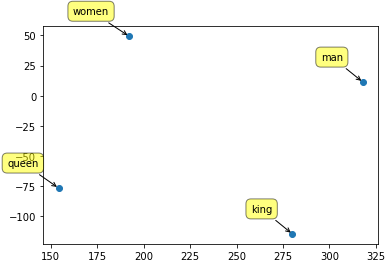

In [203]:
import matplotlib.pyplot
import pylab

x = [1,2,3,4]
y = [3,4,8,6]

matplotlib.pyplot.scatter(dimReducVecs_gender[:,0], dimReducVecs_gender[:,1])
labels = ["man", "women", "king", "queen"]
for label, x, y in zip(labels, dimReducVecs_gender[:, 0], dimReducVecs_gender[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    
matplotlib.pyplot.show()

In [204]:
X = np.array([lookupWordVec(word = "spain"), lookupWordVec(word = "madrid"),
              lookupWordVec(word = "italy"), lookupWordVec(word = "rome"),
             lookupWordVec(word = "japan"), lookupWordVec(word = "tokyo")])
dimReducVecs_caps = TSNE(n_components=2).fit_transform(X)

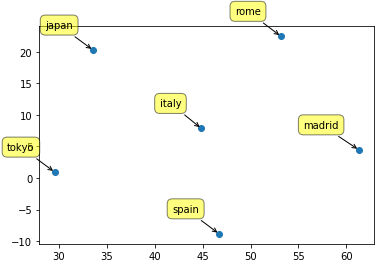

In [205]:
matplotlib.pyplot.scatter(dimReducVecs_caps[:,0], dimReducVecs_caps[:,1])
labels = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
for label, x, y in zip(labels, dimReducVecs_caps[:, 0], dimReducVecs_caps[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    
matplotlib.pyplot.show()

#### <span style="color:red">TODO: </span> describe your observation of these word vectors

Answer: **[Especially with the man-woman king-queen vectors we see some decent patterns. Word vectors should cluster next to words where they appear in the same context. As we can see this is more or less true and we see that certain vectors appear parallel to each other. We don't see perfect clustering of similar words, but this could be due to TSNE being difficult to interpret and variable, or to how long we trained our model for. Especially when it comes to the capital and country word vectors we don't see as clear a pattern as we do with the king-queen and man-women vectors. This could be due to how often these words showed up in the text and thus how well they were trained.]**